In [383]:
import pandas as pd
import seaborn as sns

In [21]:
# GeneSymbols = pd.read_csv('Human.GRCh38.p13.annot (2).tsv.gz', compression='gzip', comment='#', sep='\t')
# GeneSymbols = GeneSymbols.set_index('GeneID')['Symbol'].to_dict()

In [73]:
HugoMeta = pd.read_table('GSE78220_series_matrix.txt', sep='\t').T
HugoMeta.columns = HugoMeta.iloc[0]
HugoMeta = HugoMeta.iloc[1:,:]
HugoMeta.loc[:, 'Response'] =  HugoMeta['!Sample_source_name_ch1'].apply(lambda x : 0 if 'Progressive' in x else 1)

In [ ]:
HugoMelanoma = pd.read_table('GSE78220_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz', compression='gzip', )
HugoMelanoma = HugoMelanoma.set_index('GeneID')
HugoMelanoma.index = HugoMelanoma.index.map(GeneSymbols).values
HugoMelanoma = HugoMelanoma.T
HugoMelanoma.loc[:, "Response"] = HugoMelanoma.index.map(HugoMeta.set_index('!Sample_geo_accession')['Response'].to_dict())

In [77]:
HugoMelanoma.to_pickle('HugoMelanoma.pkl')

In [ ]:
# GenesBasedResults = pd.read_csv('../GenesBasedPrediction/All.CPGs.Genes.Results.csv',low_memory=False)
# GenesBasedResults = GenesBasedResults.drop('Unnamed: 0', axis=1).sort_values(by='PearsonR',ascending=False).drop_duplicates(subset=['CPG'], keep='first').set_index('CPG').dropna(subset='PearsonR')
TopCsvDf = GenesBasedResults[GenesBasedResults['PearsonR'] > 0.5]
# TopCsvDf.to_pickle('TopCsvDf.pkl')

In [ ]:
from combat.pycombat import pycombat
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split, LeaveOneOut
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, ElasticNetCV, Lasso
from sklearn.metrics import accuracy_score, auc, roc_curve, auc, precision_recall_curve, average_precision_score , classification_report, confusion_matrix,ConfusionMatrixDisplay,f1_score, precision_score, recall_score, matthews_corrcoef, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier , HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso
from numpy import interp
from sklearn import svm 
import matplotlib.pyplot as plt


FlipskiMelanoma = pd.read_pickle('MethylationCohorts/Flipski Melanoma.pkl')
MetastaticMelanoma = pd.read_pickle('MethylationCohorts/Metastatic Melanoma.pkl')
PrimaryMelanoma = pd.read_pickle('MethylationCohorts/Primary Melanoma.pkl')

MethScaler = StandardScaler()
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def predict_melanoma(train,datasets, classifiers, cpgs, scaler =MethScaler):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axes = list(axs.flatten())
    i = 0
    X = pd.DataFrame(scaler.fit_transform(train[cpgs]), columns=cpgs).fillna(0)
    y = train['Response']
    for classifier in classifiers:
        print('predicting using : ', type(classifier).__name__,end="\r")
        classifier.fit(X.values,y)
        for dataset in datasets:
            ax = axes[i]
            orig_labels = dataset['Response'].values
            predicted_labels = classifier.predict_proba(scaler.fit_transform(dataset[cpgs].fillna(0)))[:,1]
            fpr, tpr, thresholds = roc_curve(orig_labels,predicted_labels)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'{get_df_name(dataset)} :: ROC {round(roc_auc,2)})')
            ax.legend(loc="lower right")
            ax.set_title(f'{type(classifier).__name__}')
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
        i += 1
    plt.tight_layout()
classifiers = [LogisticRegression(random_state=42,  penalty='elasticnet', solver='saga', l1_ratio=0.0001, max_iter=50000, n_jobs=-1),
 RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=1000), 
 svm.SVC(probability=True, random_state=42), 
 LogisticRegression(random_state=42,  penalty='l1', solver='saga', max_iter=50000, n_jobs=-1)]
datasets = [FlipskiMelanoma, PrimaryMelanoma, MetastaticMelanoma]

### Hugo et Al Prediction Analysis

In [643]:
import glob
AllCpgs = glob.glob("Results/*.csv")
AllCpgs = [i for i in AllCpgs if 'GideMrna' not in i]
PreditctedDf = pd.DataFrame()
for csv in AllCpgs:
    newCSV = pd.read_csv(csv, low_memory=False)
    # newCSV = newCSV.drop('Unnamed: 0', axis=1)
    PreditctedDf = pd.concat([PreditctedDf, newCSV],axis=1)
    # try:
    # except:pass
PreditctedDf = PreditctedDf.loc[:,~PreditctedDf.columns.duplicated()].copy()
PreditctedDf = PreditctedDf.set_index('Unnamed: 0')

In [644]:
PreditctedDf["Response"] = PreditctedDf.index.map(HugoMeta.set_index('!Sample_geo_accession')['Response'].to_dict())

In [704]:
CommonCpgs = list(set(PreditctedDf.columns[:-1]).intersection(PrimaryMelanoma.columns).intersection(FlipskiMelanoma.columns).intersection(MetastaticMelanoma.columns))

In [705]:
MethScaler = StandardScaler()
ENet = LogisticRegression(random_state=42,  penalty='elasticnet', solver='saga', l1_ratio=0.0001, max_iter=50000, n_jobs=-1)
ENet.fit(MethScaler.fit_transform(PreditctedDf[CommonCpgs].fillna(0)), 
          PreditctedDf["Response"].fillna(0).values)

LogisticRegression(l1_ratio=0.0001, max_iter=50000, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')

In [706]:
SelectedCPGsDf = pd.DataFrame({"CPGs":CommonCpgs,"Score":ENet.coef_[0]}).sort_values(by='Score')
SelectedCPGs = SelectedCPGsDf.sort_values(by='Score').head(10000)['CPGs'].values

In [718]:
ENet = RandomForestClassifier(random_state=42, n_jobs=-1)
ENet.fit(MethScaler.fit_transform(PreditctedDf[SelectedCPGs].fillna(0)), 
          PreditctedDf["Response"].fillna(0).values)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [724]:
# from sklearn import metrics
# predicted_labels = ENet.predict_proba(MethScaler.fit_transform(MetastaticMelanoma[SelectedCPGs].fillna(0)))[:,1]
# fpr, tpr, thresholds = metrics.roc_curve(MetastaticMelanoma['Response'].values, 
#                                          predicted_labels)
# metrics.auc(fpr, tpr)

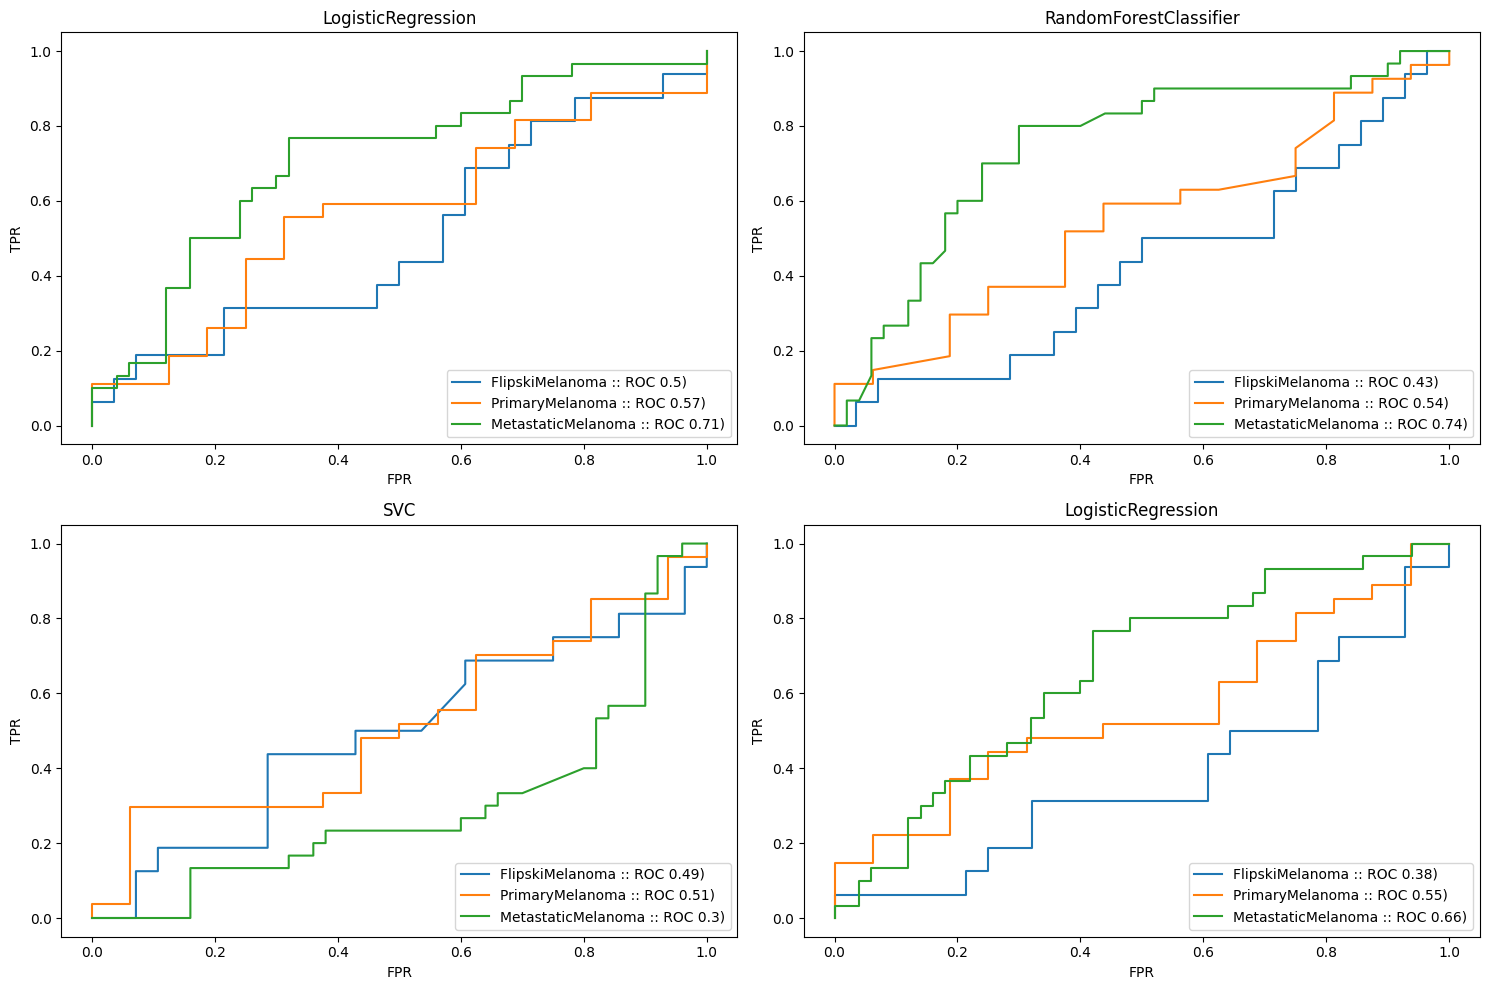

In [709]:
predict_melanoma(PreditctedDf.fillna(0),datasets, classifiers, SelectedCPGs)

In [ ]:
# sns.clustermap(PreditctedDf[SelectedCPGs], row_colors=PreditctedDf['Response'].apply(lambda x:'Red' if x == 0 else 'Blue'))

### Gide et al based prediction

In [ ]:
# GideMrna = pd.read_csv('Transcriptome/Gide.mrna.csv')
# GideMrna = GideMrna.set_index('genes').T
# GideMrna.to_pickle('GideMrna.pkl')

In [621]:
import glob
AllCpgs = glob.glob("Results/*.csv")
AllCpgs = [i for i in AllCpgs if 'GideMrna' in i]
PreditctedDf = pd.DataFrame()
for csv in AllCpgs:
    newCSV = pd.read_csv(csv, low_memory=False)
    # newCSV = newCSV.drop('Unnamed: 0', axis=1)
    PreditctedDf = pd.concat([PreditctedDf, newCSV],axis=1)
    # try:
    # except:pass
PreditctedDf = PreditctedDf.loc[:,~PreditctedDf.columns.duplicated()].copy()
PreditctedDf = PreditctedDf.set_index('Unnamed: 0')

In [622]:
# GideMeta = pd.read_csv('Transcriptome/Gide.meta.csv')
PreditctedDf.loc[:, 'Response'] = PreditctedDf.index.map(GideMeta.set_index('samples')['response'].apply(lambda x: 0 if x in ['PD','SD'] else 1))

In [623]:
CommonCpgs = list(set(PreditctedDf.columns[:-1]).intersection(PrimaryMelanoma.columns).intersection(FlipskiMelanoma.columns).intersection(MetastaticMelanoma.columns))

In [624]:
ENet = LogisticRegression(penalty='l1', solver='saga', l1_ratio=0.1)
ENet.fit(MethScaler.fit_transform(PreditctedDf[CommonCpgs].fillna(0)), 
          PreditctedDf["Response"].fillna(0).values)

LogisticRegression(l1_ratio=0.1, penalty='l1', solver='saga')

In [625]:
SelectedCPGs = pd.DataFrame({"CPGs":CommonCpgs,"Score":ENet.coef_[0]}).sort_values(by='Score')

In [626]:
SelectedCPGs = SelectedCPGs[SelectedCPGs['Score'] != 0].sort_values(by='Score')['CPGs'].values

In [627]:
ENet = LogisticRegression(random_state=42,  penalty='elasticnet', solver='saga', l1_ratio=0.0001, max_iter=50000, n_jobs=-1)
ENet.fit(MethScaler.fit_transform(PreditctedDf[SelectedCPGs].fillna(0)), 
          PreditctedDf["Response"].fillna(0).values)

LogisticRegression(l1_ratio=0.0001, max_iter=50000, n_jobs=-1,
                   penalty='elasticnet', random_state=42, solver='saga')

In [629]:
# sns.clustermap(PreditctedDf[SelectedCPGs], row_colors=PreditctedDf['Response'].apply(lambda x:'Red' if x == 0 else 'Blue'))

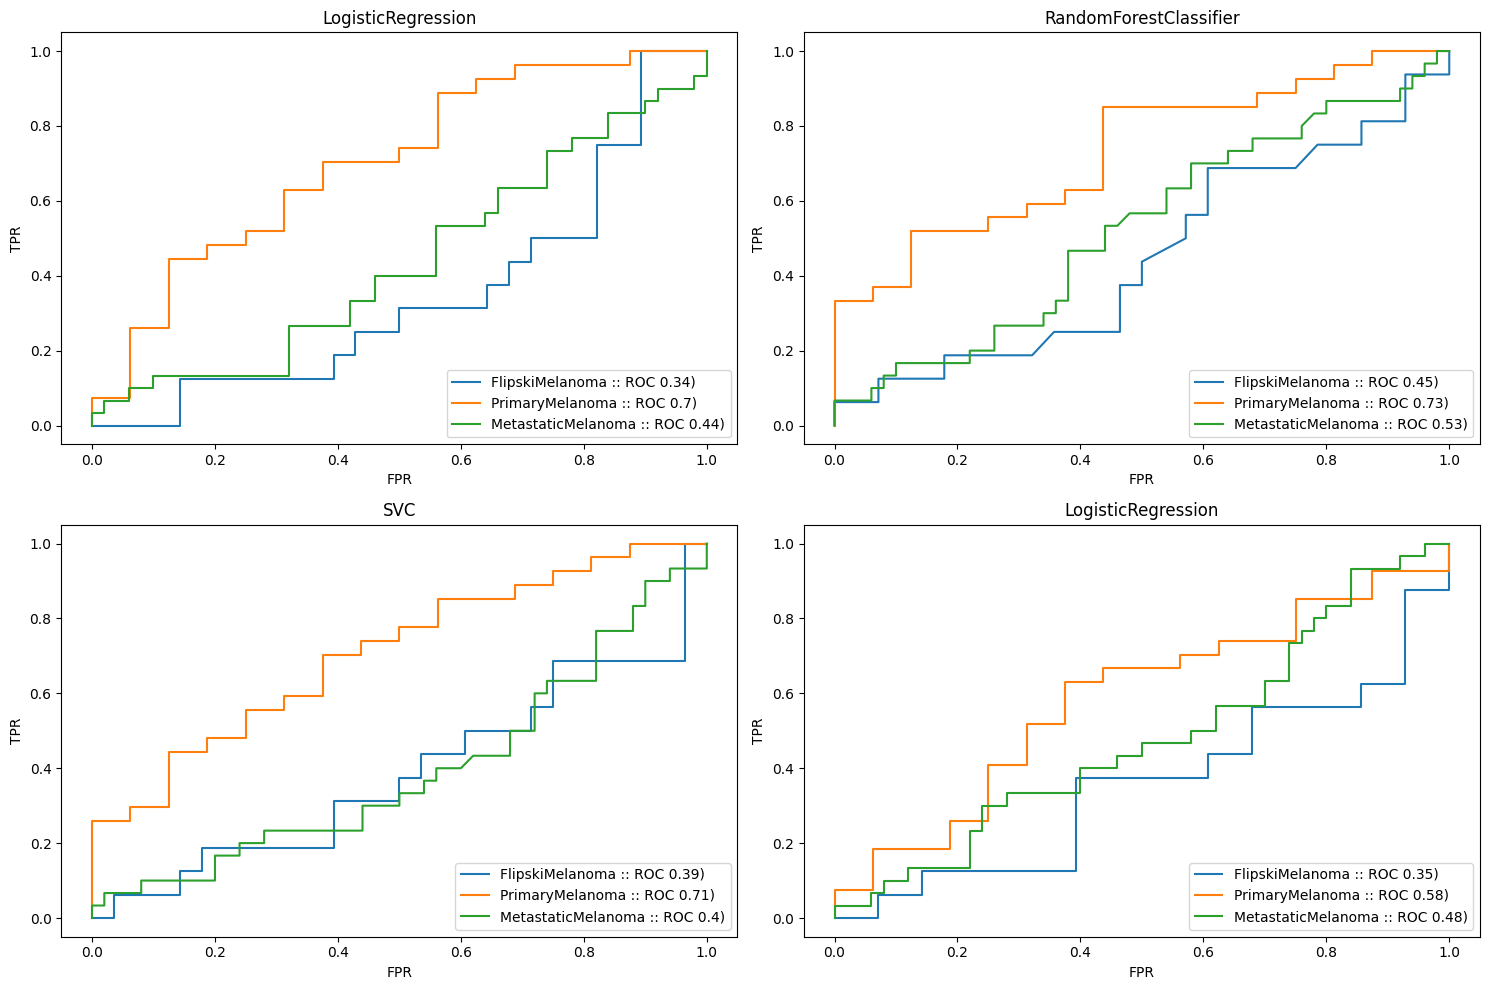

In [630]:
predict_melanoma(PreditctedDf.fillna(0),datasets, classifiers, SelectedCPGs)